# Imports

In [1]:
import os
import numpy as np
from glob import glob
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, CSVLogger
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Data Loading

In [ ]:
RTM_PATH = r'\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Datasets\11G-features\RTM_images'
DTM_PATH = r'\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Datasets\11G-features\DTM_images'
ATM_PATH = r'\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Datasets\11G-features\ATM_images'

IMG_SIZE = (32, 32)
SEQ_LEN = 5

In [ ]:
def load_and_resize_image(path):
    img = load_img(path, color_mode='grayscale', target_size=(32, 32))
    return img_to_array(img) / 255.0

# === Dataset Indexing ===
def index_multi_image_sequences(rtm_path, dtm_path, atm_path, seq_len=5, exclude_participants=None):
    all_train_samples, test_samples = [], []
    gesture_set = set()
    exclude_participants = set(exclude_participants or [])
    participants = sorted([p for p in os.listdir(rtm_path) if os.path.isdir(os.path.join(rtm_path, p))])

    for person in participants:
        is_test_person = person in exclude_participants
        for session in os.listdir(os.path.join(rtm_path, person)):
            for gesture in os.listdir(os.path.join(rtm_path, person, session)):
                rtm_seq = sorted(glob(os.path.join(rtm_path, person, session, gesture, '*.png')))
                dtm_seq = sorted(glob(os.path.join(dtm_path, person, session, gesture, '*.png')))
                atm_seq = sorted(glob(os.path.join(atm_path, person, session, gesture, '*.png')))
                if not rtm_seq or not dtm_seq or not atm_seq:
                    continue
                gesture_set.add(gesture)
                for i in range(len(rtm_seq) - seq_len + 1):
                    sample = {
                        'rtm': rtm_seq[i:i+seq_len],
                        'dtm': dtm_seq[i:i+seq_len],
                        'atm': atm_seq[i:i+seq_len],
                        'label': gesture
                    }
                    if is_test_person:
                        test_samples.append(sample)
                    else:
                        all_train_samples.append(sample)

    train_samples, val_samples = train_test_split(all_train_samples, test_size=0.2, random_state=42)
    label_map = {gesture: idx for idx, gesture in enumerate(sorted(gesture_set))}
    return train_samples, val_samples, test_samples, label_map

# === DataLoader ===
class MultiRadarSequenceGenerator(Sequence):
    def __init__(self, samples, label_map, batch_size=64, seq_len=SEQ_LEN, shuffle_data=False):
        self.samples = samples
        self.label_map = label_map
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.shuffle_data = shuffle_data
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, index):
        batch = self.samples[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__load_batch(batch)

    def on_epoch_end(self):
        if self.shuffle_data:
            self.samples = shuffle(self.samples)

    def __load_batch(self, batch_samples):
        X_rtm, X_dtm, X_atm, y = [], [], [], []
        for sample in batch_samples:
            try:
                rtm = [load_and_resize_image(p) for p in sample['rtm']]
                dtm = [load_and_resize_image(p) for p in sample['dtm']]
                atm = [load_and_resize_image(p) for p in sample['atm']]
                if len(rtm) == self.seq_len and len(dtm) == self.seq_len and len(atm) == self.seq_len:
                    rtm = np.stack(rtm)
                    dtm = np.stack(dtm)
                    atm = np.stack(atm)
                    X_rtm.append(rtm)
                    X_dtm.append(dtm)
                    X_atm.append(atm)
                    y.append(self.label_map[sample['label']])
            except Exception as e:
                print(f"Skipping corrupted sample: {e}")
                continue

        return [np.array(X_rtm), np.array(X_dtm), np.array(X_atm)], np.array(y)

In [4]:
excluded = {f'p0_{i}' for i in range(15, 21)}
train_samples, val_samples, test_samples, label_map = index_multi_image_sequences(
    RTM_PATH, DTM_PATH, ATM_PATH, seq_len=SEQ_LEN, exclude_participants=excluded
)

train_gen = MultiRadarSequenceGenerator(train_samples, label_map, batch_size=128, shuffle_data=True)
val_gen = MultiRadarSequenceGenerator(val_samples, label_map, batch_size=128)
test_gen = MultiRadarSequenceGenerator(test_samples, label_map, batch_size=32)

In [5]:
# how many train samples are there?
print(f"Number of training samples: {len(train_samples)}")
# how many test samples are there?
print(f"Number of val samples: {len(val_samples)}")
# how many test samples are there?
print(f"Number of test samples: {len(test_samples)}")
# what is the shape of the sample?
print(f"Shape of a single sample: {train_gen[0][0][0].shape}")

Number of training samples: 6497
Number of val samples: 1625
Number of test samples: 1166
Shape of a single sample: (128, 5, 32, 32, 1)


# Student 1 Network

In [ ]:
# === Small Per-Stream CNN ===
def build_light_cnn(input_shape=(32, 32, 1)):
    inp = layers.Input(shape=input_shape)
    x = layers.SeparableConv2D(8, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D(2)(x)
    x = layers.SeparableConv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    return models.Model(inp, x)

# === Student Model ===
def build_student_model(seq_len=SEQ_LEN, img_shape=(32, 32, 1), num_classes=13):
    rtm_input = layers.Input(shape=(seq_len, *img_shape), name="rtm_input")
    dtm_input = layers.Input(shape=(seq_len, *img_shape), name="dtm_input")
    atm_input = layers.Input(shape=(seq_len, *img_shape), name="atm_input")

    shared_cnn = build_light_cnn(img_shape)

    rtm_encoded = layers.TimeDistributed(shared_cnn)(rtm_input)
    dtm_encoded = layers.TimeDistributed(shared_cnn)(dtm_input)
    atm_encoded = layers.TimeDistributed(shared_cnn)(atm_input)

    x = layers.Concatenate()([rtm_encoded, dtm_encoded, atm_encoded])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=[rtm_input, dtm_input, atm_input], outputs=out)

# Distilation Module

In [6]:
class DistilledModel(tf.keras.Model):
    def __init__(self, student, teacher, alpha=0.3, temperature=5.0):
        super().__init__()
        self.student = student
        self.teacher = teacher
        self.alpha = alpha
        self.temperature = temperature

    def compile(self, optimizer, metrics, student_loss_fn, distill_loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.metrics_list = metrics
        self.student_loss_fn = student_loss_fn
        self.distill_loss_fn = distill_loss_fn

    def train_step(self, data):
        (x_rtm, x_dtm, x_atm), y_true = data
        teacher_logits = self.teacher([x_rtm, x_dtm, x_atm], training=False)

        with tf.GradientTape() as tape:
            student_logits = self.student([x_rtm, x_dtm, x_atm], training=True)
            student_loss = self.student_loss_fn(y_true, student_logits)
            distill_loss = self.distill_loss_fn(
                tf.nn.softmax(teacher_logits / self.temperature),
                tf.nn.softmax(student_logits / self.temperature)
            ) * (self.temperature ** 2)
            total_loss = self.alpha * student_loss + (1 - self.alpha) * distill_loss

        grads = tape.gradient(total_loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        for metric in self.metrics_list:
            metric.update_state(y_true, student_logits)

        return {m.name: m.result() for m in self.metrics_list}

    def test_step(self, data):
        (x_rtm, x_dtm, x_atm), y = data
        y_pred = self.student([x_rtm, x_dtm, x_atm], training=False)
        loss = self.student_loss_fn(y, y_pred)
        for metric in self.metrics_list:
            metric.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics_list}

# Student 1 Setup

In [ ]:
teacher_model = tf.keras.models.load_model(r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN\best_model_epoch46_valacc0.9803.h5", compile=False)
student_model = build_student_model(num_classes=len(label_map))

distilled = DistilledModel(student=student_model, teacher=teacher_model, alpha=0.3, temperature=5.0)
distilled.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
    distill_loss_fn=tf.keras.losses.KLDivergence()
)

# Student 1 Training

In [26]:
distilled.fit(train_gen, validation_data=val_gen, epochs=40)

Epoch 1/40
51/51 [==============================] - 78s 1s/step - sparse_categorical_accuracy: 0.0771 - val_sparse_categorical_accuracy: 0.0800
Epoch 2/40
51/51 [==============================] - 42s 821ms/step - sparse_categorical_accuracy: 0.1441 - val_sparse_categorical_accuracy: 0.2759
Epoch 3/40
51/51 [==============================] - 38s 755ms/step - sparse_categorical_accuracy: 0.2944 - val_sparse_categorical_accuracy: 0.3368
Epoch 4/40
51/51 [==============================] - 36s 703ms/step - sparse_categorical_accuracy: 0.3602 - val_sparse_categorical_accuracy: 0.3645
Epoch 5/40
51/51 [==============================] - 38s 746ms/step - sparse_categorical_accuracy: 0.3866 - val_sparse_categorical_accuracy: 0.3799
Epoch 6/40
51/51 [==============================] - 39s 775ms/step - sparse_categorical_accuracy: 0.4035 - val_sparse_categorical_accuracy: 0.3996
Epoch 7/40
51/51 [==============================] - 39s 759ms/step - sparse_categorical_accuracy: 0.4057 - val_sparse_cat

In [ ]:
student_model.save("quant_student_model_3cnn_.h5", save_format="h5")

# Student 2

In [11]:
teacher_model = tf.keras.models.load_model(r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN\best_model_epoch46_valacc0.9803.h5", compile=False)

In [9]:
def build_student_model(seq_len=5, img_shape=(32, 32, 1), num_classes=13):
    def small_cnn(input_shape):
        inp = tf.keras.Input(shape=input_shape)
        x = layers.SeparableConv2D(16, 1, activation='relu', padding='same')(inp)
        x = layers.MaxPooling2D(2)(x)
        x = layers.SeparableConv2D(32, 1, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.SeparableConv2D(64, 1, activation='relu', padding='same')(x)
        x = layers.GlobalAveragePooling2D()(x)
        return models.Model(inp, x)

    rtm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="rtm_input")
    dtm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="dtm_input")
    atm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="atm_input")

    cnn = small_cnn(img_shape)

    rtm_feat = layers.TimeDistributed(cnn)(rtm_input)
    dtm_feat = layers.TimeDistributed(cnn)(dtm_input)
    atm_feat = layers.TimeDistributed(cnn)(atm_input)

    merged = layers.Concatenate()([rtm_feat, dtm_feat, atm_feat])  # Shape: (None, 5, 64*3=192)
    x = layers.GlobalAveragePooling1D()(merged)                    # → (None, 192)

    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs=[rtm_input, dtm_input, atm_input], outputs=output)

In [10]:
student = build_student_model(num_classes=len(label_map))
student.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rtm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 dtm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 atm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 5, 64)                2737      ['rtm_input[0][0]']           
 ributed)                                                                                   

In [29]:
distilled = DistilledModel(
    student=student_model,
    teacher=teacher_model,
    alpha=0.3,            # Weight for student loss
    temperature=5.0       # Controls softness of teacher outputs
)
distilled.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
    distill_loss_fn=tf.keras.losses.KLDivergence()
)
distilled.fit(train_gen,validation_data=val_gen,epochs=40)

Epoch 1/40
51/51 [==============================] - 57s 1s/step - sparse_categorical_accuracy: 0.5617 - val_sparse_categorical_accuracy: 0.5333
Epoch 2/40
51/51 [==============================] - 55s 1s/step - sparse_categorical_accuracy: 0.5647 - val_sparse_categorical_accuracy: 0.5493
Epoch 3/40
51/51 [==============================] - 54s 1s/step - sparse_categorical_accuracy: 0.5718 - val_sparse_categorical_accuracy: 0.5382
Epoch 4/40
51/51 [==============================] - 55s 1s/step - sparse_categorical_accuracy: 0.5729 - val_sparse_categorical_accuracy: 0.5542
Epoch 5/40
51/51 [==============================] - 56s 1s/step - sparse_categorical_accuracy: 0.5741 - val_sparse_categorical_accuracy: 0.5733
Epoch 6/40
51/51 [==============================] - 55s 1s/step - sparse_categorical_accuracy: 0.5789 - val_sparse_categorical_accuracy: 0.5671
Epoch 7/40
51/51 [==============================] - 55s 1s/step - sparse_categorical_accuracy: 0.5886 - val_sparse_categorical_accuracy:

# TCN - CNN Student

In [7]:
teacher_model = tf.keras.models.load_model(r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\Models\3_radar_CNN\best_model_epoch46_valacc0.9803.h5", compile=False)

In [12]:
from tensorflow.keras import layers, models, Input
from tcn import TCN

def build_student_model(seq_len=5, img_shape=(32, 32, 1), num_classes=13):
    def small_cnn(input_shape):
        inp = Input(shape=input_shape)

        # Block 1
        x = layers.SeparableConv2D(16, 3, activation='relu', padding='same')(inp)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(2)(x)

        # Block 2
        x = layers.SeparableConv2D(32, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(2)(x)

        # Block 3
        x = layers.SeparableConv2D(64, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Global Pooling
        x = layers.GlobalAveragePooling2D()(x)

        return models.Model(inp, x)

    # === Inputs ===
    rtm_input = Input(shape=(seq_len, *img_shape), name="rtm_input")
    dtm_input = Input(shape=(seq_len, *img_shape), name="dtm_input")
    atm_input = Input(shape=(seq_len, *img_shape), name="atm_input")

    cnn_encoder = small_cnn(img_shape)

    # === Encode each modality ===
    rtm_feat = layers.TimeDistributed(cnn_encoder)(rtm_input)  # (batch, seq_len, 64)
    dtm_feat = layers.TimeDistributed(cnn_encoder)(dtm_input)
    atm_feat = layers.TimeDistributed(cnn_encoder)(atm_input)

    # === Fuse all modalities ===
    merged = layers.Concatenate()([rtm_feat, dtm_feat, atm_feat])  # (batch, seq_len, 192)

    # === Temporal Modeling ===
    x = TCN(64, dilations=[1, 2, 4, 8], kernel_size=3, return_sequences=False)(merged)
    x = layers.Dropout(0.3)(x)

    # === Dense Head ===
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs=[rtm_input, dtm_input, atm_input], outputs=output)


In [13]:
student_model = build_student_model(num_classes=len(label_map))
student_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rtm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 dtm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 atm_input (InputLayer)      [(None, 5, 32, 32, 1)]       0         []                            
                                                                                                  
 time_distributed_3 (TimeDi  (None, 5, 64)                3577      ['rtm_input[0][0]']           
 stributed)                                                                                 

In [14]:
student_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

pretrain_callbacks = [
    EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=5, restore_best_weights=True, verbose=1),
    CSVLogger("pretraining_log_student.csv", append=False)
]

print("Phase 1: Pretraining student without teacher")
student_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,  # You can tune this
    callbacks=pretrain_callbacks
)

Phase 1: Pretraining student without teacher
Epoch 1/15
51/51 [==============================] - 40s 724ms/step - loss: 2.6292 - sparse_categorical_accuracy: 0.1128 - val_loss: 2.5904 - val_sparse_categorical_accuracy: 0.0948
Epoch 2/15
51/51 [==============================] - 35s 687ms/step - loss: 2.3033 - sparse_categorical_accuracy: 0.2178 - val_loss: 2.3609 - val_sparse_categorical_accuracy: 0.2506
Epoch 3/15
51/51 [==============================] - 36s 713ms/step - loss: 2.0625 - sparse_categorical_accuracy: 0.3029 - val_loss: 2.0269 - val_sparse_categorical_accuracy: 0.4126
Epoch 4/15
51/51 [==============================] - 36s 702ms/step - loss: 1.8585 - sparse_categorical_accuracy: 0.3739 - val_loss: 1.8373 - val_sparse_categorical_accuracy: 0.4458
Epoch 5/15
51/51 [==============================] - 36s 703ms/step - loss: 1.6853 - sparse_categorical_accuracy: 0.4322 - val_loss: 1.7414 - val_sparse_categorical_accuracy: 0.4193
Epoch 6/15
51/51 [==============================] 

In [15]:
# === Phase 2: Distillation Training ===
distilled = DistilledModel(
    student=student_model,   # now contains pretrained weights
    teacher=teacher_model,
    alpha=0.5,
    temperature=2.0
)

distilled.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
    distill_loss_fn=tf.keras.losses.KLDivergence()
)

distill_callbacks = [
    ReduceLROnPlateau(monitor="val_sparse_categorical_accuracy", factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=10, restore_best_weights=True, verbose=1),
    CSVLogger("distillation_log_student.csv", append=False)
]

print("Phase 2: Knowledge distillation with teacher guidance")
distilled.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,  # Additive; total training time = pretrain + this
    callbacks=distill_callbacks
)

Phase 2: Knowledge distillation with teacher guidance
Epoch 1/30
51/51 [==============================] - 41s 732ms/step - sparse_categorical_accuracy: 0.4234 - val_sparse_categorical_accuracy: 0.4249 - lr: 1.0000e-04
Epoch 2/30
51/51 [==============================] - 35s 693ms/step - sparse_categorical_accuracy: 0.4830 - val_sparse_categorical_accuracy: 0.4076 - lr: 1.0000e-04
Epoch 3/30
51/51 [==============================] - 36s 712ms/step - sparse_categorical_accuracy: 0.5153 - val_sparse_categorical_accuracy: 0.3861 - lr: 1.0000e-04
Epoch 4/30
51/51 [==============================] - 36s 710ms/step - sparse_categorical_accuracy: 0.5482 - val_sparse_categorical_accuracy: 0.4052 - lr: 1.0000e-04
Epoch 5/30
51/51 [==============================] - 36s 712ms/step - sparse_categorical_accuracy: 0.5660 - val_sparse_categorical_accuracy: 0.3947 - lr: 1.0000e-04
Epoch 6/30
51/51 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.5928
Epoch 6: ReduceLROnPlateau r

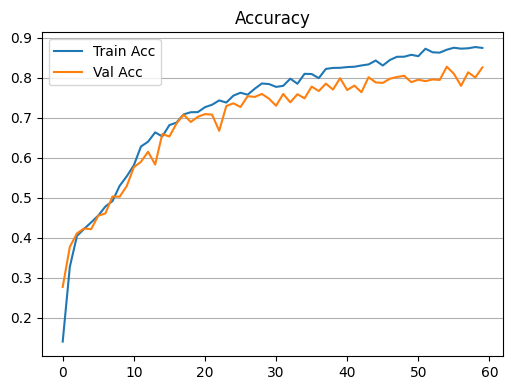

In [93]:
log = pd.read_csv(r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\training_log_tcn_student_2.csv")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
plt.plot(log["epoch"], log["sparse_categorical_accuracy"], label="Train Acc")
plt.plot(log["epoch"], log["val_sparse_categorical_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")
plt.tight_layout()
# only horizontal grid
plt.grid(axis='y')
plt.show()

In [94]:
student_model.save("student_model_tcn.h5", save_format="h5")

In [95]:
model_path = r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\student_model_tcn.h5"
size_bytes = os.path.getsize(model_path)
size_kb = size_bytes / 1024
size_mb = size_kb / 1024

print(f"Model size: {size_kb:.2f} KB ({size_mb:.2f} MB)")

Model size: 862.66 KB (0.84 MB)


# Testing Full Model

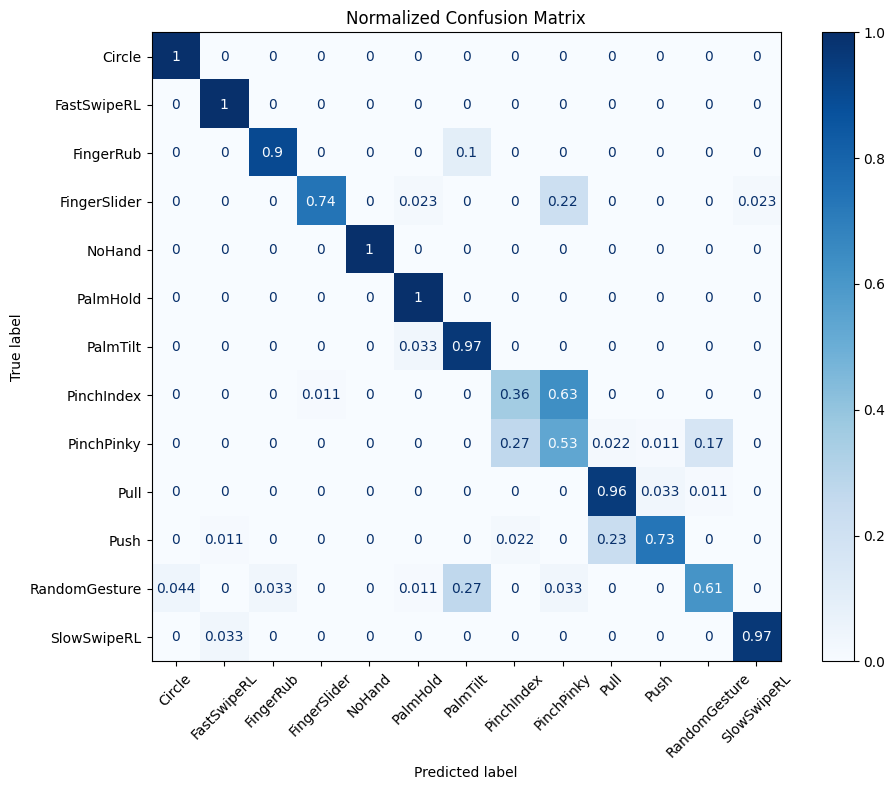

Classification Report:
               precision    recall  f1-score   support

       Circle     0.9574    1.0000    0.9783        90
  FastSwipeRL     0.9574    1.0000    0.9783        90
    FingerRub     0.9643    0.9000    0.9310        90
 FingerSlider     0.9846    0.7356    0.8421        87
       NoHand     1.0000    1.0000    1.0000        90
     PalmHold     0.9368    1.0000    0.9674        89
     PalmTilt     0.7250    0.9667    0.8286        90
   PinchIndex     0.5517    0.3556    0.4324        90
   PinchPinky     0.3780    0.5333    0.4424        90
         Pull     0.7890    0.9556    0.8643        90
         Push     0.9429    0.7333    0.8250        90
RandomGesture     0.7746    0.6111    0.6832        90
  SlowSwipeRL     0.9775    0.9667    0.9721        90

     accuracy                         0.8276      1166
    macro avg     0.8415    0.8275    0.8265      1166
 weighted avg     0.8410    0.8276    0.8264      1166


 Overall Accuracy: 0.8276
All classes 

In [97]:
y_true_all = []
y_pred_all = []

for X_batch, y_batch in test_gen:
    y_probs = student_model.predict(X_batch, verbose=0)
    preds = np.argmax(y_probs, axis=1)
    y_true_all.extend(y_batch)
    y_pred_all.extend(preds)

y_true = np.array(y_true_all)
y_pred = np.array(y_pred_all)

# === Confusion matrix ===
num_classes = len(label_map)
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
cm_normalized = np.nan_to_num(cm_normalized)

# === Plot confusion matrix ===
class_names = [label for label, _ in sorted(label_map.items(), key=lambda x: x[1])]
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=True, ax=ax)

ax.set_title("Normalized Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# === Accuracy report ===
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

total_acc = accuracy_score(y_true, y_pred)
print(f"\n Overall Accuracy: {total_acc:.4f}")

# === Optional: Missing predictions
missing = set(range(num_classes)) - set(np.unique(y_pred))
if missing:
    print(f"Classes never predicted: {missing}")
else:
    print("All classes were predicted at least once.")

# Quantization of Student TCN + 3 CNN - float 16

In [10]:
model = tf.keras.models.load_model(
    r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\Good_Models\student_model_tcn.h5",
    custom_objects={"TCN": TCN}  # if needed
)

# Wrap in tf.function with correct shape signature (batch=1)
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32),
    tf.TensorSpec(shape=[1, 5, 32, 32, 3], dtype=tf.float32),
])
def wrapped_model(rtm, dtm, atm):
    return model([rtm, dtm, atm])

# Get concrete function
concrete_func = wrapped_model.get_concrete_function()

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

# Enable optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Target float16
converter.target_spec.supported_types = [tf.float32]

# Still allows float32 input/output for compatibility
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert and save
tflite_model_fp16 = converter.convert()
with open("student_tcn_float32.tflite", "wb") as f:
    f.write(tflite_model_fp16)

print("Saved: student_tcn_float32.tflite")

Saved: student_tcn_float32.tflite


In [11]:
def plot_conf_matrix(y_true, y_pred, label_map, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(label_map)))
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)
    
    class_names = [label for label, _ in sorted(label_map.items(), key=lambda x: x[1])]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(xticks_rotation=45, cmap="Blues", ax=ax, colorbar=True)
    ax.set_title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

In [12]:
def evaluate_tflite_model(tflite_model_path, test_gen, label_map):
    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    y_true_all = []
    y_pred_all = []

    for X_batch, y_batch in test_gen:
        for i in range(len(y_batch)):
            input_data = [
                X_batch[j][i:i+1].astype(input_details[j]["dtype"])  # cast to expected dtype
                for j in range(3)
            ]

            # Set inputs
            for j in range(3):
                interpreter.set_tensor(input_details[j]["index"], input_data[j])

            # Run inference
            interpreter.invoke()

            output_data = interpreter.get_tensor(output_details[0]["index"])
            pred = np.argmax(output_data[0])
            y_pred_all.append(pred)
            y_true_all.append(y_batch[i])

    # Metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    print(f"Accuracy: {acc:.4f}")

    class_names = [label for label, _ in sorted(label_map.items(), key=lambda x: x[1])]
    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all, target_names=class_names))

    return y_true_all, y_pred_all


In [17]:
print("Testing float16 quantized model")
y_true_fp16, y_pred_fp16 = evaluate_tflite_model(r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training\Good_Models\student_model_tcn_float16.tflite", test_gen, label_map)

Testing float16 quantized model
Accuracy: 0.8285

Classification Report:
               precision    recall  f1-score   support

       Circle       0.96      1.00      0.98        90
  FastSwipeRL       0.96      1.00      0.98        90
    FingerRub       0.96      0.90      0.93        90
 FingerSlider       0.98      0.75      0.85        87
       NoHand       1.00      1.00      1.00        90
     PalmHold       0.94      1.00      0.97        89
     PalmTilt       0.72      0.97      0.83        90
   PinchIndex       0.55      0.36      0.43        90
   PinchPinky       0.38      0.53      0.44        90
         Pull       0.79      0.96      0.86        90
         Push       0.94      0.73      0.82        90
RandomGesture       0.77      0.61      0.68        90
  SlowSwipeRL       0.98      0.97      0.97        90

     accuracy                           0.83      1166
    macro avg       0.84      0.83      0.83      1166
 weighted avg       0.84      0.83      0.83 

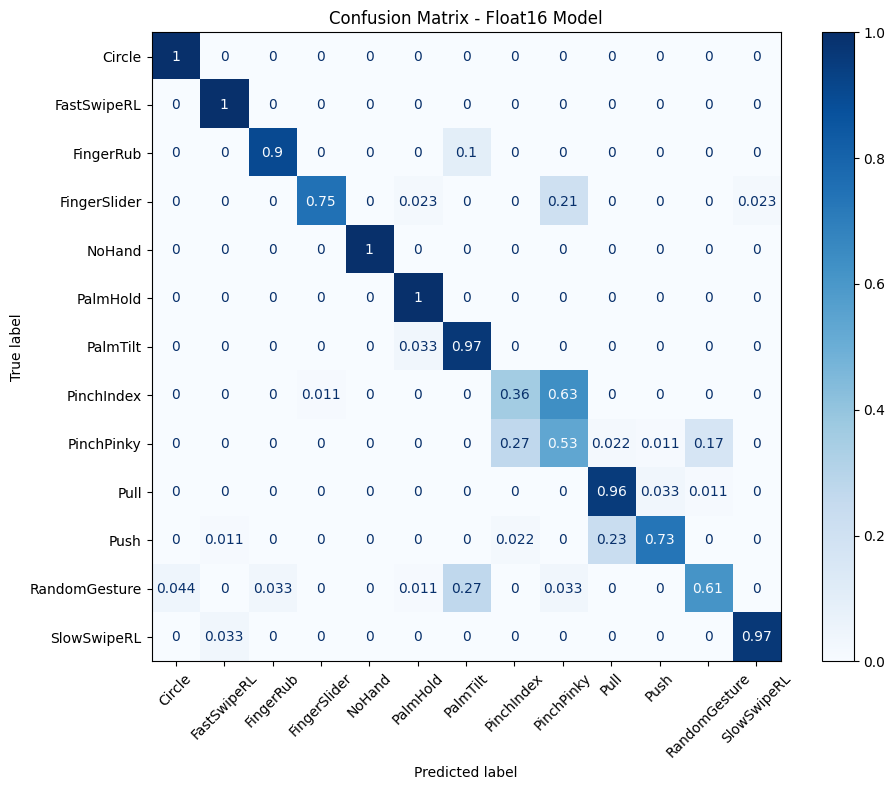

In [108]:
plot_conf_matrix(y_true_fp16, y_pred_fp16, label_map, title="Confusion Matrix - Float16 Model")


# Quantization of Student TCN + 3 CNN - int 8

In [119]:
def representative_dataset():
    count = 0
    max_samples = 100  # Adjust this as needed
    for X, _ in test_gen:
        for i in range(len(X[0])):
            if count >= max_samples:
                return
            rtm = X[0][i:i+1].astype(np.float32)
            dtm = X[1][i:i+1].astype(np.float32)
            atm = X[2][i:i+1].astype(np.float32)
            yield [rtm, dtm, atm]
            count += 1

In [122]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# Force full int8 quantization
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, 
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert and save
tflite_model_int8 = converter.convert()
with open("student_tcn_int8.tflite", "wb") as f:
    f.write(tflite_model_int8)

print("Saved: student_tcn_int8.tflite")

c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Saved: student_tcn_int8.tflite


In [123]:
print("\n Testing int8 quantized model")
y_true_int8, y_pred_int8 = evaluate_tflite_model("student_tcn_int8.tflite", test_gen, label_map)



 Testing int8 quantized model
Accuracy: 0.8268

Classification Report:
               precision    recall  f1-score   support

       Circle       0.96      1.00      0.98        90
  FastSwipeRL       0.96      1.00      0.98        90
    FingerRub       0.94      0.91      0.93        90
 FingerSlider       0.97      0.77      0.86        87
       NoHand       1.00      1.00      1.00        90
     PalmHold       0.95      1.00      0.97        89
     PalmTilt       0.72      0.97      0.82        90
   PinchIndex       0.57      0.34      0.43        90
   PinchPinky       0.38      0.52      0.44        90
         Pull       0.77      0.96      0.86        90
         Push       0.93      0.72      0.81        90
RandomGesture       0.76      0.59      0.66        90
  SlowSwipeRL       0.98      0.97      0.97        90

     accuracy                           0.83      1166
    macro avg       0.84      0.83      0.82      1166
 weighted avg       0.84      0.83      0.82  

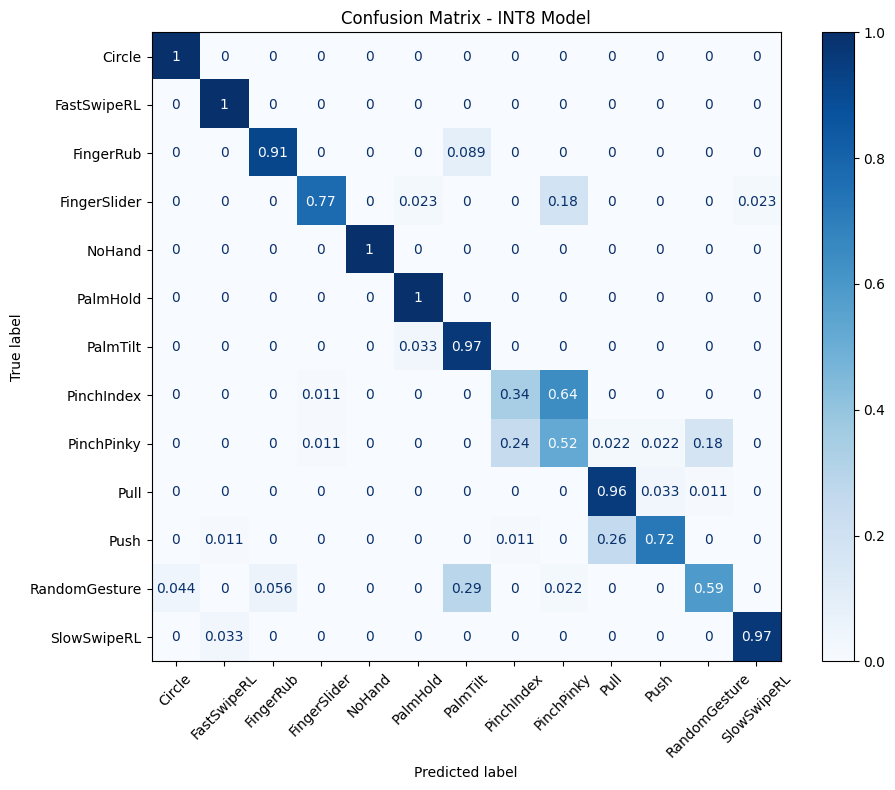

In [124]:
plot_conf_matrix(y_true_int8, y_pred_int8, label_map, title="Confusion Matrix - INT8 Model")

In [129]:
y_true = []
y_probs = []
interpreter = tf.lite.Interpreter(model_path="student_tcn_int8.tflite")
interpreter.allocate_tensors()    
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for X_batch, y_batch in test_gen:
    for i in range(len(X_batch[0])):  # batch size
        rtm = X_batch[0][i:i+1].astype(np.float32)
        dtm = X_batch[1][i:i+1].astype(np.float32)
        atm = X_batch[2][i:i+1].astype(np.float32)

        interpreter.set_tensor(input_details[0]['index'], rtm)
        interpreter.set_tensor(input_details[1]['index'], dtm)
        interpreter.set_tensor(input_details[2]['index'], atm)

        interpreter.invoke()
        probs = interpreter.get_tensor(output_details[0]['index'])[0]

        y_probs.append(probs)
        y_true.append(y_batch[i])

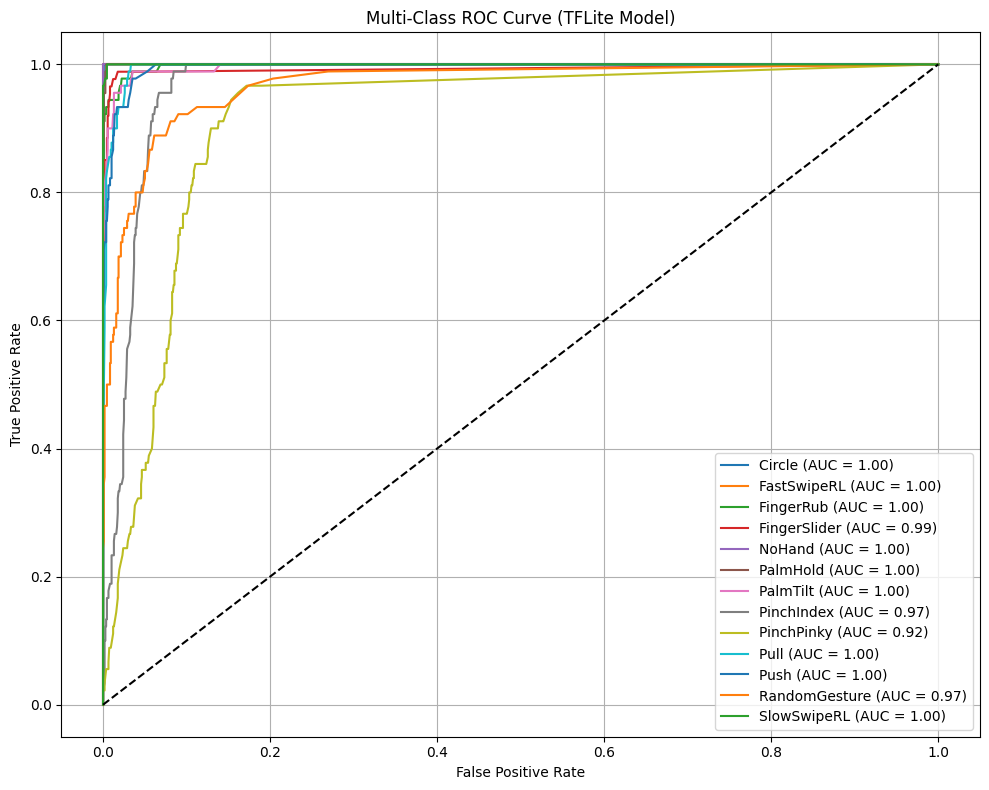

In [130]:
num_classes = len(label_map)
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_probs = np.array(y_probs)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    class_name = [k for k, v in label_map.items() if v == i][0]
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve (TFLite Model)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [131]:
size_kb = os.path.getsize("student_tcn_int8.tflite") / 1024
print(f"TFLite model size: {size_kb:.2f} KB")

TFLite model size: 277.61 KB
